In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import spearmanr

from bio_if.data.utils import FastaDataset, FixedIndexTokenizer
from bio_if.modules.mlp import MLPBlock

In [2]:
tokenizer_fn = FixedIndexTokenizer()

In [5]:
src = '../src/bio_if/data/FLIP/gb1/'
tasks = ['one_vs_rest', 'two_vs_rest', 'three_vs_rest', 'sampled']
datasets = {}
for task in tasks:
    datasets[task] = {}
    datasets[task]['train'] = FastaDataset(f'{src}/{task}.fasta', split='train', tokenizer_fn=tokenizer_fn)
    datasets[task]['val'] = FastaDataset(f'{src}/{task}.fasta', split='val', tokenizer_fn=tokenizer_fn)
    datasets[task]['test'] = FastaDataset(f'{src}/{task}.fasta', split='test', tokenizer_fn=tokenizer_fn)

In [6]:
# define an MLP
def init_regressor():
    D = 128
    return nn.Sequential(
        MLPBlock(80, D, use_relu=True),
        MLPBlock(D, D, use_relu=True),
        MLPBlock(D, 1, use_relu=False)
    )

In [11]:
dataloaders = {}
for task in tasks:
    dataloaders[task] = {
        'train': datasets[task]['train'].get_dataloader(batch_size=32, shuffle=True, drop_last=False),
        'val': datasets[task]['val'].get_dataloader(batch_size=32, shuffle=False, drop_last=False),
        'test': datasets[task]['test'].get_dataloader(batch_size=32, shuffle=False, drop_last=False)
    }
DEVICE = 'cuda:7'

In [12]:
def get_val_loss(model, dataloader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids, labels = batch
            input_ids, labels = input_ids.to(DEVICE), labels.to(DEVICE)
            outputs = model(input_ids).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    return val_loss / len(dataloader)

In [20]:
def train_model(train_dataloader, val_dataloader, test_dataloader):
    EPOCHS = 10 # 00
    N_VAL_ATTEMPTS = 5
    LR = 1e-2

    loss_fn = nn.MSELoss()
    best_val_loss = float('inf')

    val_failures = 0
    model = init_regressor().to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.1, )

    losses = []
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        for batch in tqdm(train_dataloader):
            input_ids, labels = batch
            input_ids, labels = input_ids.to(DEVICE), labels.to(DEVICE)
            outputs = model(input_ids).squeeze()
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()

        val_loss = get_val_loss(model, val_dataloader, loss_fn)
        print(f'Epoch {epoch} train loss: {train_loss / len(train_dataloader)}')
        print(f'Epoch {epoch} val loss: {val_loss}')
        losses.append((train_loss / len(train_dataloader), val_loss))

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            val_failures = 0
            best_model = model.state_dict()
        else:
            val_failures += 1
            if val_failures >= N_VAL_ATTEMPTS:
                print(f'Early stopping at epoch {epoch}')
                break

    model.load_state_dict(best_model)
    # make a plot of the training and validation losses
    train_losses, val_losses = zip(*losses)
    test_loss = get_val_loss(model, test_dataloader, loss_fn)
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.axhline(test_loss, color='r', linestyle='--', label='test')
    plt.legend()
    return model

100%|██████████| 1/1 [00:00<00:00, 83.86it/s]


Epoch 0 train loss: 3.617591381072998
Epoch 0 val loss: 0.4459448754787445


100%|██████████| 1/1 [00:00<00:00, 94.26it/s]


Epoch 1 train loss: 2.5531368255615234
Epoch 1 val loss: 0.13458426296710968


100%|██████████| 1/1 [00:00<00:00, 99.96it/s]


Epoch 2 train loss: 1.5716758966445923
Epoch 2 val loss: 0.2910228371620178


100%|██████████| 1/1 [00:00<00:00, 103.91it/s]


Epoch 3 train loss: 0.8268405199050903
Epoch 3 val loss: 1.4426555633544922


100%|██████████| 1/1 [00:00<00:00, 91.23it/s]


Epoch 4 train loss: 1.312726378440857
Epoch 4 val loss: 1.2174359560012817


100%|██████████| 1/1 [00:00<00:00, 98.74it/s]


Epoch 5 train loss: 1.1150449514389038
Epoch 5 val loss: 0.5949225425720215


100%|██████████| 1/1 [00:00<00:00, 103.26it/s]


Epoch 6 train loss: 0.634854257106781
Epoch 6 val loss: 0.2374715805053711
Early stopping at epoch 6


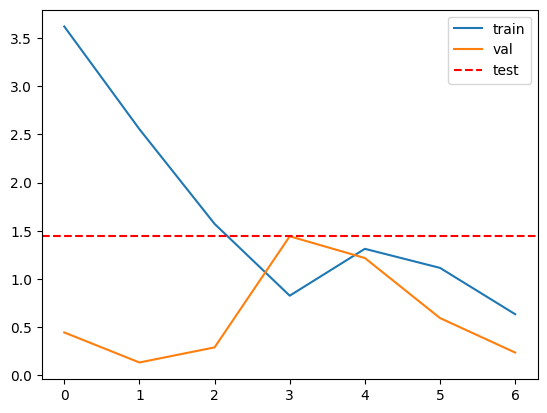

In [21]:
# train one vs rest
one_vs_rest_model = train_model(dataloaders['one_vs_rest']['train'], dataloaders['one_vs_rest']['val'], dataloaders['one_vs_rest']['test'])

100%|██████████| 12/12 [00:00<00:00, 210.02it/s]


Epoch 0 train loss: 1.4561313291390736
Epoch 0 val loss: 0.9163149297237396


100%|██████████| 12/12 [00:00<00:00, 219.02it/s]


Epoch 1 train loss: 0.6016303946574529
Epoch 1 val loss: 0.5617217123508453


100%|██████████| 12/12 [00:00<00:00, 211.62it/s]


Epoch 2 train loss: 0.3259426603714625
Epoch 2 val loss: 0.6063688397407532


100%|██████████| 12/12 [00:00<00:00, 219.94it/s]


Epoch 3 train loss: 0.2393688547114531
Epoch 3 val loss: 0.6787912845611572


100%|██████████| 12/12 [00:00<00:00, 193.58it/s]


Epoch 4 train loss: 0.15500718541443348
Epoch 4 val loss: 0.6429360806941986


100%|██████████| 12/12 [00:00<00:00, 144.71it/s]


Epoch 5 train loss: 0.11145457377036412
Epoch 5 val loss: 0.5826708078384399


100%|██████████| 12/12 [00:00<00:00, 187.92it/s]


Epoch 6 train loss: 0.08160127140581608
Epoch 6 val loss: 0.5840969383716583
Early stopping at epoch 6


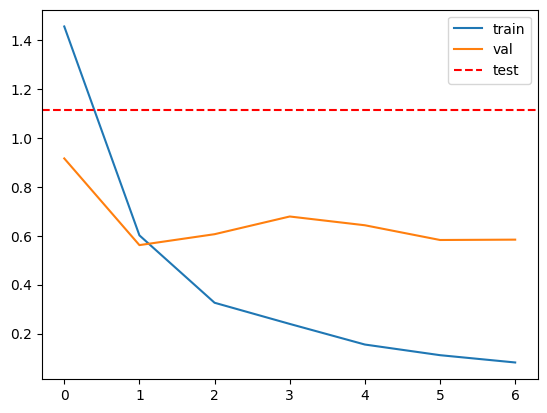

In [22]:
# train two vs rest
two_vs_rest_model = train_model(dataloaders['two_vs_rest']['train'], dataloaders['two_vs_rest']['val'], dataloaders['two_vs_rest']['test'])

100%|██████████| 85/85 [00:00<00:00, 246.32it/s]


Epoch 0 train loss: 0.7747826927725007
Epoch 0 val loss: 0.5553415581583977


100%|██████████| 85/85 [00:00<00:00, 245.19it/s]


Epoch 1 train loss: 0.3339354048756992
Epoch 1 val loss: 0.3418372102081776


100%|██████████| 85/85 [00:00<00:00, 247.97it/s]


Epoch 2 train loss: 0.2515194288948003
Epoch 2 val loss: 0.2880870677530766


100%|██████████| 85/85 [00:00<00:00, 251.60it/s]


Epoch 3 train loss: 0.16089368182070116
Epoch 3 val loss: 0.21860034838318826


100%|██████████| 85/85 [00:00<00:00, 254.35it/s]


Epoch 4 train loss: 0.1463035176782047
Epoch 4 val loss: 0.18376702666282654


100%|██████████| 85/85 [00:00<00:00, 244.42it/s]


Epoch 5 train loss: 0.12806712454732727
Epoch 5 val loss: 0.24690108224749566


100%|██████████| 85/85 [00:00<00:00, 217.61it/s]


Epoch 6 train loss: 0.10878021445344477
Epoch 6 val loss: 0.15783802159130572


100%|██████████| 85/85 [00:00<00:00, 230.93it/s]


Epoch 7 train loss: 0.11798680800506298
Epoch 7 val loss: 0.17573576830327511


100%|██████████| 85/85 [00:00<00:00, 247.70it/s]


Epoch 8 train loss: 0.08281649603124927
Epoch 8 val loss: 0.15491164550185205


100%|██████████| 85/85 [00:00<00:00, 254.13it/s]


Epoch 9 train loss: 0.0880532891215647
Epoch 9 val loss: 0.20890115275979043


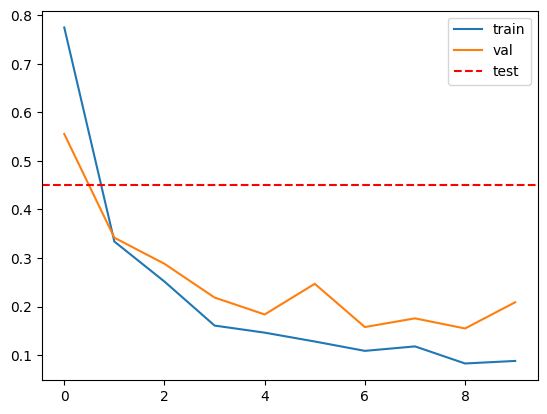

In [23]:
# train three vs rest
three_vs_rest_model = train_model(dataloaders['three_vs_rest']['train'], dataloaders['three_vs_rest']['val'], dataloaders['three_vs_rest']['test'])

100%|██████████| 197/197 [00:01<00:00, 179.22it/s]


Epoch 0 train loss: 0.5715103976163768
Epoch 0 val loss: 0.33071457052772696


100%|██████████| 197/197 [00:00<00:00, 216.46it/s]


Epoch 1 train loss: 0.269271624572386
Epoch 1 val loss: 0.27556602555242454


100%|██████████| 197/197 [00:00<00:00, 216.03it/s]


Epoch 2 train loss: 0.2232126254342534
Epoch 2 val loss: 0.23974607326090336


100%|██████████| 197/197 [00:00<00:00, 215.19it/s]


Epoch 3 train loss: 0.17991836304743278
Epoch 3 val loss: 0.2267282891341231


100%|██████████| 197/197 [00:00<00:00, 215.15it/s]


Epoch 4 train loss: 0.15989862267060329
Epoch 4 val loss: 0.25513324327766895


100%|██████████| 197/197 [00:00<00:00, 245.78it/s]


Epoch 5 train loss: 0.15461691349820436
Epoch 5 val loss: 0.2243617976253683


100%|██████████| 197/197 [00:00<00:00, 252.47it/s]


Epoch 6 train loss: 0.15059555246291426
Epoch 6 val loss: 0.20053989152339372


100%|██████████| 197/197 [00:00<00:00, 253.94it/s]


Epoch 7 train loss: 0.14587137031222358
Epoch 7 val loss: 0.26476433500647545


100%|██████████| 197/197 [00:00<00:00, 251.51it/s]


Epoch 8 train loss: 0.14682568023501313
Epoch 8 val loss: 0.19567795571955768


100%|██████████| 197/197 [00:00<00:00, 246.81it/s]


Epoch 9 train loss: 0.13612922740542344
Epoch 9 val loss: 0.19696901620111681


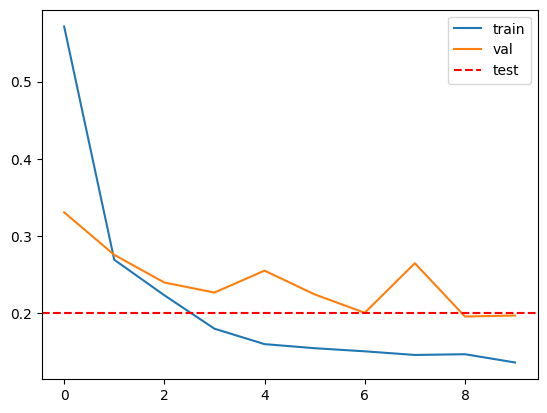

In [24]:
# train sampled
sampled_model = train_model(dataloaders['sampled']['train'], dataloaders['sampled']['val'], dataloaders['sampled']['test'])

In [33]:
def get_correlation(model, dataloader):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids, label = batch
            input_ids, label = input_ids.to(DEVICE), label.to(DEVICE)
            outputs = model(input_ids).reshape(-1)
            preds.append(outputs)
            labels.append(label)
    preds = torch.cat(preds).numpy(force=True)
    labels = torch.cat(labels).numpy(force=True)
    return spearmanr(preds, labels), preds, labels

In [34]:
# get correlations and predictions for each model on all tasks and splits
correlations = {}
predictions = {}
labels = {}
for task in tasks:
    correlations[task] = {}
    predictions[task] = {}
    labels[task] = {}
    for split in ['train', 'val', 'test']:
        correlations[task][split], predictions[task][split], labels[task][split] = get_correlation(locals()[f'{task}_model'], dataloaders[task][split])


In [35]:
# print the correlations
for task in tasks:
    for split in ['train', 'val', 'test']:
        print(f'{task} {split} spearman correlation: {correlations[task][split][0]}')

one_vs_rest train spearman correlation: 0.8676923076923077
one_vs_rest val spearman correlation: -1.0
one_vs_rest test spearman correlation: 0.228714248032563
two_vs_rest train spearman correlation: 0.9574182555462347
two_vs_rest val spearman correlation: 0.6519178495922682
two_vs_rest test spearman correlation: 0.633932016466857
three_vs_rest train spearman correlation: 0.9564692986287072
three_vs_rest val spearman correlation: 0.8978017573942217
three_vs_rest test spearman correlation: 0.8548162956238737
sampled train spearman correlation: 0.9454153407111212
sampled val spearman correlation: 0.9343533655490364
sampled test spearman correlation: 0.9227926160507965


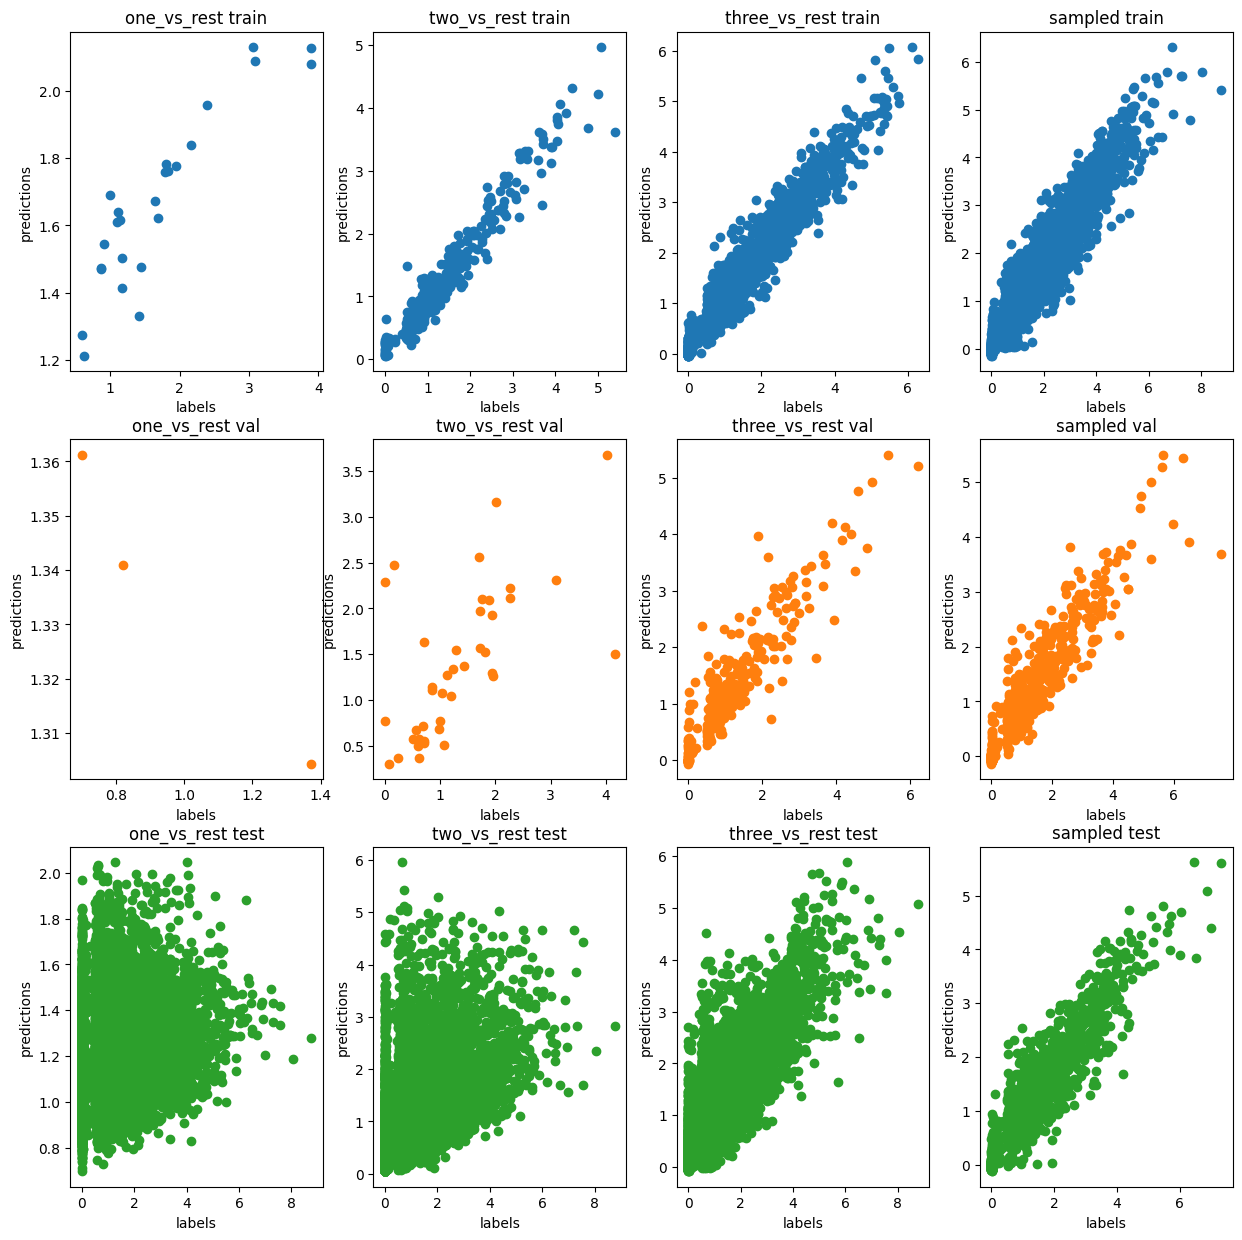

In [38]:
# make a grid of 3 rows and 4 columns with the following plots:
# each row is a split
# each column is a task
# each plot is a scatter plot of the predictions vs the labels
color = {
    'train': 'C0',
    'val': 'C1',
    'test': 'C2'
}
fig, axs = plt.subplots(3, 4, figsize=(15, 15))
for i, task in enumerate(tasks):
    for j, split in enumerate(['train', 'val', 'test']):
        
        axs[j, i].scatter(labels[task][split], predictions[task][split], color=color[split])
        axs[j, i].set_title(f'{task} {split}')
        axs[j, i].set_xlabel('labels')
        axs[j, i].set_ylabel('predictions')



In [39]:
# compute influence function of the model
from bio_if.modules.influence import influence

In [40]:
def get_test_influence(train_dataset, test_dataset, model):
    # turn train dataset into a list
    train_list = list(train_dataset)
    test_list = list(test_dataset)

    # "tokenize" the first value of each tuple
    train_list = [(tokenizer_fn(x).reshape(1, -1), y) for x, y in train_list]
    test_list = [(tokenizer_fn(x).reshape(1, -1), y) for x, y in test_list]

    influences = influence(
        model,
        list(model),
        test_list,
        train_list,
        train_list,
        DEVICE,
        torch.nn.functional.mse_loss, aggregate_query_grads=True
    )

In [41]:
influences = {}
for task in tasks:
    print(f'Computing influence for {task}')
    influences[task] = get_test_influence(datasets[task]['train'], datasets[task]['test'], locals()[f'{task}_model'])

Computing influence for one_vs_rest
Computing EKFAC factors and pseudo gradients


  0%|          | 0/25 [00:00<?, ?it/s]/home/cadegord/projects/bio-if/src/bio_if/modules/influence.py:61: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(output, target)
100%|██████████| 25/25 [00:00<00:00, 250.77it/s]


Computing search gradients


  0%|          | 0/25 [00:00<?, ?it/s]/home/cadegord/projects/bio-if/src/bio_if/modules/influence.py:96: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(output, target)
100%|██████████| 25/25 [00:00<00:00, 365.55it/s]

Computing iHVP



100%|██████████| 1/1 [00:00<00:00, 221.83it/s]


Computing influence for two_vs_rest
Computing EKFAC factors and pseudo gradients


100%|██████████| 381/381 [00:02<00:00, 188.31it/s]


Computing search gradients


100%|██████████| 381/381 [00:01<00:00, 229.24it/s]


Computing iHVP


100%|██████████| 1/1 [00:00<00:00, 181.73it/s]


Computing influence for three_vs_rest
Computing EKFAC factors and pseudo gradients


100%|██████████| 2691/2691 [00:13<00:00, 198.48it/s]


Computing search gradients


100%|██████████| 2691/2691 [00:12<00:00, 222.51it/s]


Computing iHVP


100%|██████████| 1/1 [00:00<00:00, 219.64it/s]


Computing influence for sampled
Computing EKFAC factors and pseudo gradients


100%|██████████| 6289/6289 [00:31<00:00, 201.04it/s]


Computing search gradients


100%|██████████| 6289/6289 [00:27<00:00, 227.19it/s]


Computing iHVP


100%|██████████| 1/1 [00:00<00:00, 210.31it/s]


In [44]:
# save all models and influences to a folder stamped with the date and time
import os
from datetime import datetime
now = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
os.makedirs(f'cached_runs/gb1/{now}', exist_ok=True)
# save the models state dicts and influences
torch.save(one_vs_rest_model.state_dict(), f'cached_runs/gb1/{now}/one_vs_rest_model.pt')
torch.save(two_vs_rest_model.state_dict(), f'cached_runs/gb1/{now}/two_vs_rest_model.pt')
torch.save(three_vs_rest_model.state_dict(), f'cached_runs/gb1/{now}/three_vs_rest_model.pt')
torch.save(sampled_model.state_dict(), f'cached_runs/gb1/{now}/sampled_model.pt')
torch.save(influences, f'cached_runs/gb1/{now}/influences.pt')

In [16]:
import seaborn as sns
import numpy as np

In [53]:
# sort influences and take top 1 percent
influences_sorted = torch.sort(influences).values.numpy(force=True)
n = len(influences_sorted)
top_1_percent = influences_sorted[int(n * 0.99):]
n_top_1 = len(top_1_percent)
# cdf: y = 1 - (x / x_min) ** -alpha
# 1-y = (x / x_min) ** -alpha
# log(1-y) = -alpha * log(x / x_min)
# fit a power law to the top 1 percent
# fit ridge regression to the above equation
log_y = np.log(1-np.linspace(0.99, 1, n_top_1, endpoint=False))
log_y_mean = log_y.mean()
log_x = np.log(top_1_percent) - np.log(top_1_percent.min())
log_x_mean = log_x.mean()
alpha = -np.sum((log_x - log_x_mean) * (log_y - log_y_mean)) / np.sum((log_x - log_x_mean) ** 2)
print(f'alpha: {alpha}')

alpha: 2.3342674892071202


0.00011755652345862647
73.598236 6.7097473 -2.3342674892071202 -0.0009534093311566083


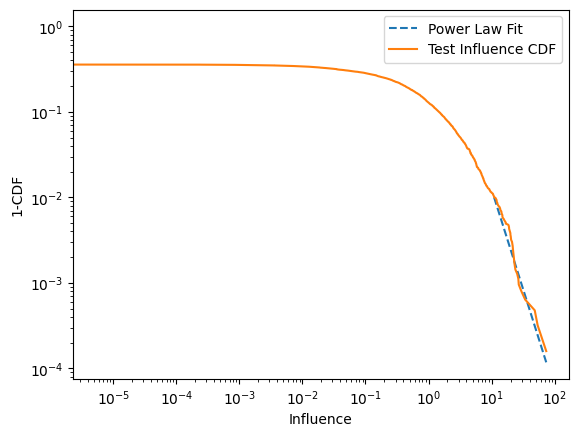

In [71]:
complementary_cdf = 1-np.linspace(0, 1, n, endpoint=False)
# plot a power law to the top 1 percent
# v = (top_1_percent[-1]/top_1_percent[0])**-alpha
m = top_1_percent[0]
v = np.exp(np.log(0.01)-alpha * (np.log(top_1_percent[-1]/m) - np.log(top_1_percent[0]/m)))
print(v)
plt.plot((top_1_percent[0], top_1_percent[-1]), (0.01, v), label='Power Law Fit', linestyle='--')
print(top_1_percent[-1], top_1_percent[-1]/top_1_percent[0], -alpha, (complementary_cdf[-1]-0.01)*np.exp(-alpha))
# sns.lineplot([top_1_percent[0], top_1_percent[-1]], [0.01, 0], label='Power Law Fit')

# plot a CDF of the influences
plt.plot(influences_sorted, complementary_cdf, label='Test Influence CDF')
plt.xlabel('Influence')
plt.ylabel('1-CDF')
# make the plot log-log
plt.xscale('log')
plt.yscale('log')
plt.legend()